In [25]:
from glob import glob
import datetime

import numpy as np
from astropy.table import Table
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [4]:
from matplotlib.ticker import MultipleLocator

Why do this?

## Gather the data

### HR

+ redshift cut
+ HR cut

In [5]:
HR = pd.read_csv('../data/campbell_local.tsv', sep='\t', usecols=['SNID', 'redshift', 'hr', 'err_mu'], index_col='SNID')
HR.rename(columns={'err_mu': 'hr uncert'}, inplace=True)
HR = HR[HR['redshift']<0.2]  
HR = HR[HR['hr']<0.7]
HR.describe()

,redshift,hr uncert,hr
count,103.000000,103.000000,103.000000
mean,0.143292,0.078358,-0.023348
std,0.042126,0.016502,0.185996
min,0.045248,0.056201,-0.495474
25%,0.114303,0.065649,-0.152180
50%,0.154056,0.075748,-0.037427
75%,0.180766,0.085845,0.090790
max,0.198704,0.133972,0.497041


### SALT2 parameters (x_1 & c)

In [6]:
t = Table.read('../data/SDSS_Photometric_SNe_Ia.fits')
salt = t['CID','Z','X1','X1_ERR','COLOR','COLOR_ERR'].to_pandas()
salt.columns = salt.columns.str.lower()
salt.rename(columns={'cid': 'SNID', 'z': 'redshift'}, inplace=True)
salt.set_index('SNID', inplace=True)
salt.describe()

,redshift,x1,x1_err,color,color_err
count,752.000000,752.000000,752.000000,752.000000,752.000000
mean,0.294032,-0.006514,0.765859,-0.013105,0.059070
std,0.103553,1.082517,0.506811,0.100019,0.023878
min,0.037069,-2.952440,0.061210,-0.245912,0.024959
25%,0.220188,-0.776738,0.426394,-0.084207,0.041157
50%,0.294489,0.022410,0.702974,-0.019256,0.055565
75%,0.369411,0.793196,1.011968,0.051200,0.073263
max,0.700345,2.887440,8.048070,0.246569,0.195758


### Stellar Mass

In [7]:
galaxy = pd.read_csv('../resources/kcorrect_stellarmass.csv',  usecols=['GAL', 'redshift', 'stellarmass'], index_col='GAL')
galaxy.rename(columns={'redshift': 'gal redshift', 'stellarmass': 'stellar mass'}, inplace=True)
galaxy.describe()

,gal redshift,stellar mass
count,305.000000,3.050000e+02
mean,0.223845,4.177042e+10
std,0.071923,5.006189e+10
min,0.045363,3.521470e+07
25%,0.175242,8.513790e+09
50%,0.236310,2.342800e+10
75%,0.284038,5.800110e+10
max,0.336325,3.486340e+11


### Age

In [8]:
age = pd.read_csv('../resources/ages_campbell.tsv', sep='\t',  skiprows=[1],
                   usecols=['# sn id', 'age'], dtype={'age': np.float64, '# sn id': np.int})
age.rename(columns={'# sn id': 'SNID'}, inplace=True)
age.set_index('SNID', inplace=True)
age.describe()

,age
count,103.000000
mean,5.221552
std,2.121162
min,1.628953
25%,3.447774
50%,5.071533
75%,6.625620
max,9.740748


In [9]:
age_global = pd.read_csv('../resources/ages_campbellG.tsv', sep='\t',  skiprows=[1],
                         usecols=['# sn id', 'age'], dtype={'age': np.float64, '# sn id': np.int})
age_global.rename(columns={'# sn id': 'SNID'}, inplace=True)
age_global.set_index('SNID', inplace=True)
age_global.describe()

,age
count,103.000000
mean,5.489302
std,2.256922
min,1.206989
25%,4.082504
50%,5.312133
75%,7.369338
max,10.738602


### Combine

In [10]:
data = pd.concat([HR, salt, galaxy, age], axis=1)
data.dropna(inplace=True)
data.describe()

,redshift,hr uncert,hr,redshift,x1,x1_err,color,color_err,gal redshift,stellar mass,age
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,1.030000e+02,103.000000
mean,0.143292,0.078358,-0.023348,0.143292,-0.177168,0.268273,0.010006,0.032914,0.143292,3.082438e+10,5.221552
std,0.042126,0.016502,0.185996,0.042126,1.020424,0.127680,0.083329,0.006243,0.042150,3.486086e+10,2.121162
min,0.045248,0.056201,-0.495474,0.045248,-2.641650,0.061210,-0.201667,0.024959,0.045363,3.521470e+07,1.628953
25%,0.114303,0.065649,-0.152180,0.114303,-0.769090,0.176328,-0.041371,0.028793,0.114276,5.819550e+09,3.447774
50%,0.154056,0.075748,-0.037427,0.154056,-0.115550,0.236314,-0.004241,0.030807,0.154034,2.032040e+10,5.071533
75%,0.180766,0.085845,0.090790,0.180766,0.693757,0.354695,0.081210,0.035345,0.180752,4.306880e+10,6.625620
max,0.198704,0.133972,0.497041,0.198704,1.812530,0.635581,0.246569,0.054852,0.198706,2.267200e+11,9.740748


Convert stellar mass to be log(stellar mass)

In [11]:
data['stellar mass'] = np.log10(data['stellar mass'])
data.describe()

,redshift,hr uncert,hr,redshift,x1,x1_err,color,color_err,gal redshift,stellar mass,age
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,0.143292,0.078358,-0.023348,0.143292,-0.177168,0.268273,0.010006,0.032914,0.143292,10.152806,5.221552
std,0.042126,0.016502,0.185996,0.042126,1.020424,0.127680,0.083329,0.006243,0.042150,0.693578,2.121162
min,0.045248,0.056201,-0.495474,0.045248,-2.641650,0.061210,-0.201667,0.024959,0.045363,7.546724,1.628953
25%,0.114303,0.065649,-0.152180,0.114303,-0.769090,0.176328,-0.041371,0.028793,0.114276,9.764876,3.447774
50%,0.154056,0.075748,-0.037427,0.154056,-0.115550,0.236314,-0.004241,0.030807,0.154034,10.307932,5.071533
75%,0.180766,0.085845,0.090790,0.180766,0.693757,0.354695,0.081210,0.035345,0.180752,10.632817,6.625620
max,0.198704,0.133972,0.497041,0.198704,1.812530,0.635581,0.246569,0.054852,0.198706,11.355490,9.740748


In [12]:
# now with global
data_global = pd.concat([HR, salt, galaxy, age_global], axis=1)
data_global.dropna(inplace=True)
data_global.describe()

data_global['stellar mass'] = np.log10(data_global['stellar mass'])
data_global.describe()

,redshift,hr uncert,hr,redshift,x1,x1_err,color,color_err,gal redshift,stellar mass,age
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,0.143292,0.078358,-0.023348,0.143292,-0.177168,0.268273,0.010006,0.032914,0.143292,10.152806,5.489302
std,0.042126,0.016502,0.185996,0.042126,1.020424,0.127680,0.083329,0.006243,0.042150,0.693578,2.256922
min,0.045248,0.056201,-0.495474,0.045248,-2.641650,0.061210,-0.201667,0.024959,0.045363,7.546724,1.206989
25%,0.114303,0.065649,-0.152180,0.114303,-0.769090,0.176328,-0.041371,0.028793,0.114276,9.764876,4.082504
50%,0.154056,0.075748,-0.037427,0.154056,-0.115550,0.236314,-0.004241,0.030807,0.154034,10.307932,5.312133
75%,0.180766,0.085845,0.090790,0.180766,0.693757,0.354695,0.081210,0.035345,0.180752,10.632817,7.369338
max,0.198704,0.133972,0.497041,0.198704,1.812530,0.635581,0.246569,0.054852,0.198706,11.355490,10.738602


## PCA

Standardize the variables. We will do everything in their "linear" (looking at you distance modulus/HR) space excepct for stellar mass.

In [13]:
# Lets remove uncertainties & redshift?
features = ['x1', 'color', 'stellar mass', 'age']
y = data.loc[:, features].values
scaler = StandardScaler()
scaler.fit(y)   # get the needed transformation off of y
y.shape

(103, 4)

In [14]:
scaler.mean_, scaler.var_

(array([-1.77167739e-01,  1.00061104e-02,  1.01528061e+01,  5.22155160e+00]),
 array([1.0311568 , 0.00687628, 0.47638034, 4.45564521]))

In [15]:
pca2 = PCA(n_components=4)
principalComponents2 = pca2.fit_transform(y)

In [16]:
principalComponents2.shape

(103, 4)

In [17]:
pca2.components_

array([[-0.25637326,  0.00124183,  0.15275461,  0.95443032],
       [-0.96457075,  0.01133911,  0.02211423, -0.26265121],
       [-0.06121118,  0.00181082, -0.98801577,  0.14168536],
       [ 0.01136734,  0.9999333 ,  0.00134876,  0.00153652]])

In [18]:
pca2.singular_values_
## this is not what I wanted I guess. Use `explained_variance_ratio_`

array([22.2930907 ,  8.88207305,  6.19238316,  0.83505349])

In [19]:
pca2.explained_variance_ratio_

array([0.80821098, 0.12829592, 0.0623591 , 0.001134  ])

In [30]:
# need for data table in paper
principalComponents2[:,0]

array([-0.29061487,  1.14091138,  3.33876989, -1.73289561,  0.59014357,
       -1.66445306, -3.43245255,  0.21858377, -1.88854234, -2.81342426,
       -2.35254232, -2.07008673, -2.77672712, -3.71969204,  1.23032792,
       -1.69729632,  3.21542734,  0.55050329,  1.10933584,  1.0396035 ,
       -2.31998914,  3.1193025 ,  0.48770088, -2.14312385,  2.23526803,
        4.74066724,  3.60245063, -2.40183598,  2.7664978 , -1.34500594,
       -0.46819231, -2.6909712 , -0.60121564,  1.3632084 , -1.16623189,
        0.06208877,  0.35596031,  1.32640853, -2.97169968,  0.50553392,
        0.54749442, -2.96197672, -1.39383272,  2.01745944, -0.16676026,
        0.04820339,  0.44125531,  1.00323321, -1.59258311,  3.3362115 ,
       -0.51617587, -0.71364366, -0.14336215, -0.70884045,  0.99075612,
       -2.45666571,  3.1358163 ,  0.03123446, -3.76166304, -2.1232177 ,
       -0.17336268,  2.16242223, -2.55132307, -1.471261  ,  0.44408534,
       -2.18970585,  3.77596923,  1.40180788,  2.45528576, -1.62

### PCA without HR -- Global

In [20]:
# Lets remove uncertainties & redshift?
features = ['x1', 'color', 'stellar mass', 'age']
y = data_global.loc[:, features].values
scaler = StandardScaler()
scaler.fit(y)   # get the needed transformation off of y
y.shape

(103, 4)

In [21]:
scaler.mean_, scaler.var_

(array([-1.77167739e-01,  1.00061104e-02,  1.01528061e+01,  5.48930218e+00]),
 array([1.0311568 , 0.00687628, 0.47638034, 5.04424391]))

In [22]:
pca_global = PCA(n_components=4)
principalComponents_global = pca_global.fit_transform(y)
principalComponents_global.shape

(103, 4)

In [23]:
print(pca_global.components_)
print(pca_global.singular_values_) # not what I want
print(pca_global.singular_values_/pca_global.singular_values_.sum())  #not what I wanted.
print(pca_global.explained_variance_ratio_)

[[-1.99031038e-01  3.49523357e-03  2.00197952e-01  9.59320181e-01]
 [-9.79961043e-01  7.38756074e-03 -4.04916953e-02 -1.94890230e-01]
 [-7.62401296e-05  1.20817761e-02 -9.78851689e-01  2.04214093e-01]
 [ 7.93694719e-03  9.99893613e-01  1.14268789e-02 -4.38101973e-03]]
[23.65777323  9.35467668  5.25820684  0.83231903]
[0.60501209 0.23923184 0.13447076 0.02128531]
[0.82850582 0.12954045 0.04092825 0.00102548]


### Plots

In [23]:
spearmanr(principalComponents2[:,0], data['hr'])

SpearmanrResult(correlation=-0.56044897421253803, pvalue=7.455362583660209e-10)

5.7x10^-7 is a 5-sigma significance
8.03x10^-11 is a 6.5-sigma significance
2.55x10^-12 is a 7-sigma significance
1.52x10^-23 is a 10-sigma significance

In [24]:
(m, b), cov = np.polyfit(principalComponents2[:,0], data['hr'], 1, full=False, cov=True)
print(m, b)
print(cov)
print(np.sqrt(cov[0,0]), np.sqrt(cov[1,1]))

-0.0461715527789 -0.0233478282494
[[  5.01847836e-05   2.18001175e-20]
 [  2.18001175e-20   2.42144939e-04]]
0.00708412193402 0.0155610070146


In [27]:
(m, b), cov = np.polyfit(principalComponents_global[:,0], data['hr'], 1, full=False, cov=True)
print(m, b)
print(cov)
print(np.sqrt(cov[0,0]), np.sqrt(cov[1,1]))

-0.035974830465 -0.0233478282494
[[  5.06102360e-05   4.17497652e-20]
 [  4.17497652e-20   2.75010241e-04]]
0.00711408714868 0.0165834327277


In [25]:
rms = lambda x: np.sqrt(x.dot(x)/x.size)

In [33]:
# RMS around HR = 0 
print(rms(data['hr']))
print(data['hr'].std())

0.186557248652
0.185995573737


In [34]:
# RMS around trendline
print("local RMS: ", rms(data['hr'] - (-0.04617155*principalComponents2[:,0] - 0.0233478)))
print("global RMS: ", rms(data['hr'] - (-0.0359748*principalComponents_global[:,0] - 0.0233478)))
print("local STD: ", (data['hr'] - (-0.04617155*principalComponents2[:,0] - 0.0233478)).std())
print("global STD: ", (data['hr'] - (-0.0359748*principalComponents_global[:,0] - 0.0233478)).std())

local RMS:  0.154830064883
global RMS:  0.165003072282
local STD:  0.15558718463
global STD:  0.165809938083


/usr/local/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


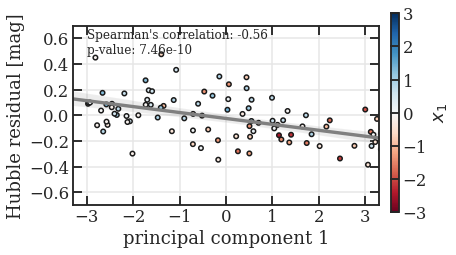

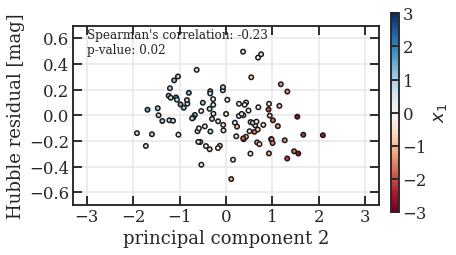

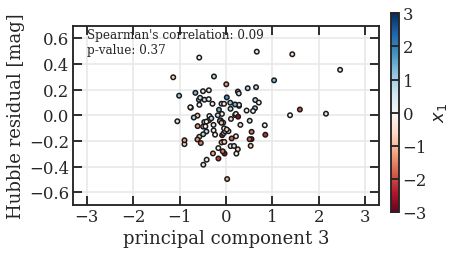

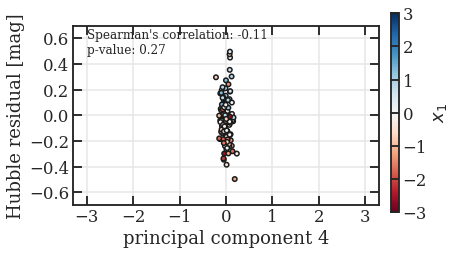

In [27]:
sns.set(context='talk', style='ticks', font='serif', color_codes=True)

for i in [0,1,2,3]:
    fig = plt.figure()
    
    #fix axes major spacing & size
    ax = plt.gca()
    ax.get_yaxis().set_major_locator(MultipleLocator(0.2))
    ax.set_ylim(-0.7, 0.7)
    ax.get_xaxis().set_major_locator(MultipleLocator(1))
    ax.set_xlim(-3.3, 3.3)

    #set axes ticks and gridlines
    ax.tick_params(axis='both', top='on', right='on', direction='in')
    ax.grid(which='major', axis='both', color='0.90', linestyle='-')
    ax.set_axisbelow(True)
    
    #show origin
#     ax.axhline(y=0, color='0.8', linewidth=2)
#     ax.axvline(x=0, color='0.8', linewidth=1)

   ## add best fit on PC_1 -- under data points
    if i==0:
#         x = np.linspace(min(principalComponents2[:,i]), max(principalComponents2[:,i]), 100)
#         print(m*x+b)
#         plt.plot(x, m*x+b)
        sns.regplot(principalComponents2[:,i], data['hr'], marker='', color='grey', ax=ax)
    
    #plot data on top -- not needed down here if we don't try to show the origin
    plt.scatter(principalComponents2[:,i], data['hr'], marker='.', c=data['x1'],
                cmap="RdBu", vmin=-3.0, vmax=3.0, edgecolor='k')
    
    
    # add axes labels, after sns.regplot
    plt.xlabel(f'principal component {i+1}')
    plt.ylabel('Hubble residual [mag]')
    
    #Add colorbar
    ##["{:>4.1f}".format(y) for y in yticks] as possible color bar formating.
    cax = fig.add_axes([0.95, 0.217, 0.02, 0.691])   # fig.set_tight_layout({'pad': 1.5})
#     cax = fig.add_axes([0.965, 0.2, 0.02, 0.691])   # plt.tight_layout()
    cax.tick_params(axis='y', direction='in')
    cax.set_axisbelow(False)   # bring tick marks above coloring
    plt.colorbar(label=r"$x_1$", cax=cax)
    
    
    #add Spearman's correlation
    ##add a back color so the grid lines do not get in the way?
    sp_r, sp_p = spearmanr(principalComponents2[:,i], data['hr'])
    if i==0:
        ax.text(-3, 0.48, f"Spearman's correlation: {sp_r:.2f}\np-value: {sp_p:.2e}", 
                {'fontsize':12})
    else:
        ax.text(-3, 0.48, f"Spearman's correlation: {sp_r:.2f}\np-value: {sp_p:.2f}", 
                {'fontsize':12})
    
    fig.set_tight_layout({'pad': 1.5})
    plt.savefig(f'HRvPC{i+1}.pdf', bbox_inches='tight')   # bbox to make space for the colorbar
    plt.show()

### Plots - Global

In [64]:
m, b = np.polyfit(principalComponents_global[:,0], data['hr'],1)
print(m, b)

-0.035974830465 -0.0233478282494


/usr/local/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


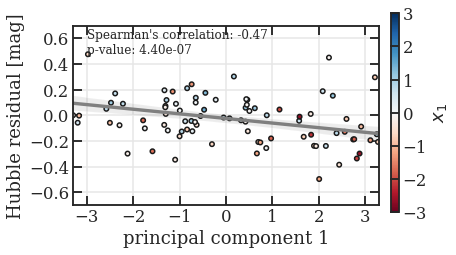

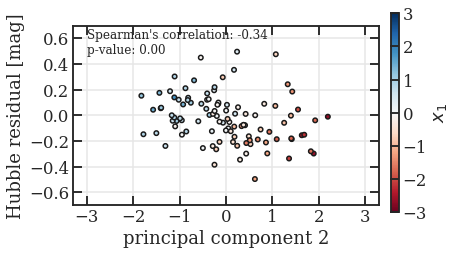

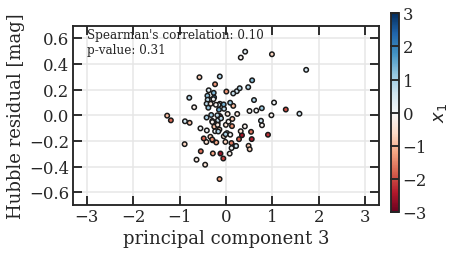

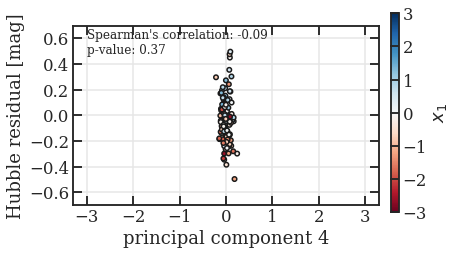

In [28]:
sns.set(context='talk', style='ticks', font='serif', color_codes=True)

for i in [0,1,2,3]:
    fig = plt.figure()
    
    #fix axes major spacing & size
    ax = plt.gca()
    ax.get_yaxis().set_major_locator(MultipleLocator(0.2))
    ax.set_ylim(-0.7, 0.7)
    ax.get_xaxis().set_major_locator(MultipleLocator(1))
    ax.set_xlim(-3.3, 3.3)

    #set axes ticks and gridlines
    ax.tick_params(axis='both', top='on', right='on', direction='in')
    ax.grid(which='major', axis='both', color='0.90', linestyle='-')
    ax.set_axisbelow(True)
    
    #show origin
#     ax.axhline(y=0, color='0.8', linewidth=2)
#     ax.axvline(x=0, color='0.8', linewidth=1)

   ## add best fit on PC_1 -- under data points
    if i==0:
#         x = np.linspace(min(principalComponents_global[:,i]), max(principalComponents_global[:,i]), 100)
#         print(m*x+b)
#         plt.plot(x, m*x+b)
        sns.regplot(principalComponents_global[:,i], data['hr'], marker='', color='grey', ax=ax)
    
    #plot data on top -- not needed down here if we don't try to show the origin
    plt.scatter(principalComponents_global[:,i], data['hr'], marker='.', c=data['x1'],
               cmap="RdBu", vmin=-3.0, vmax=3.0, edgecolor='k')
    
    
    # add axes labels, after sns.regplot
    plt.xlabel(f'principal component {i+1}')
    plt.ylabel('Hubble residual [mag]')
    
    #Add colorbar
    ##["{:>4.1f}".format(y) for y in yticks] as possible color bar formating.
    cax = fig.add_axes([0.95, 0.217, 0.02, 0.691])   # fig.set_tight_layout({'pad': 1.5})
#     cax = fig.add_axes([0.965, 0.2, 0.02, 0.691])   # plt.tight_layout()
    cax.tick_params(axis='y', direction='in')
    cax.set_axisbelow(False)   # bring tick marks above coloring
    plt.colorbar(label=r"$x_1$", cax=cax)
    
    
    #add Spearman's correlation
    ##add a back color so the grid lines do not get in the way?
    sp_r, sp_p = spearmanr(principalComponents_global[:,i], data['hr'])
    if i==0:
        ax.text(-3, 0.48, f"Spearman's correlation: {sp_r:.2f}\np-value: {sp_p:.2e}", 
                {'fontsize':12})
    else:
        ax.text(-3, 0.48, f"Spearman's correlation: {sp_r:.2f}\np-value: {sp_p:.2f}", 
                {'fontsize':12})
    
    fig.set_tight_layout({'pad': 1.5})
    plt.savefig(f'HRvPC{i+1}_global.pdf', bbox_inches='tight')   # bbox to make space for the colorbar
    plt.show()

# Correation between $x_1$, Mass, and Age

In [65]:
import corner
import matplotlib

In [30]:
sns.set(context='talk', style='ticks', font='serif', color_codes=True)

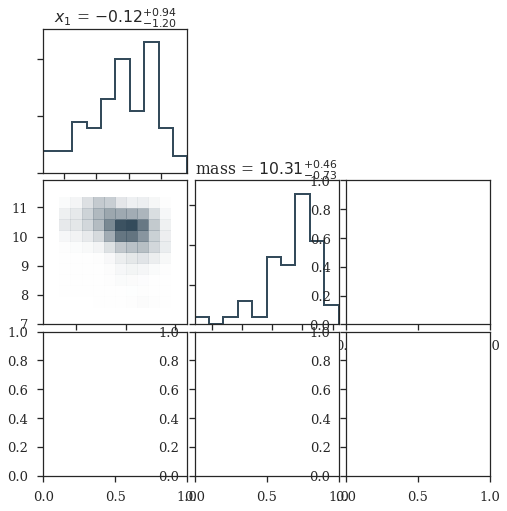

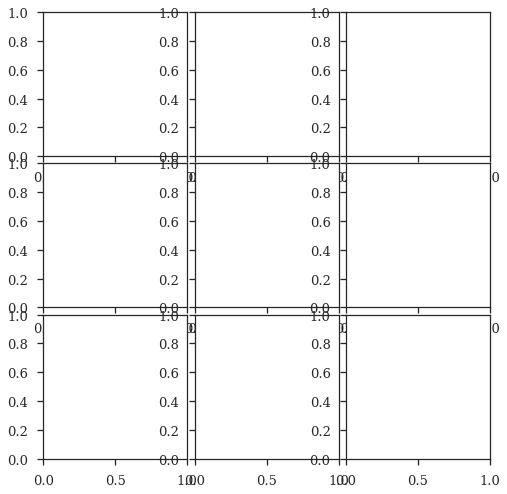

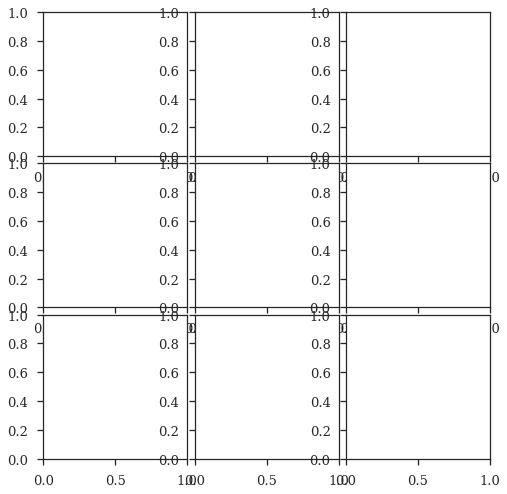

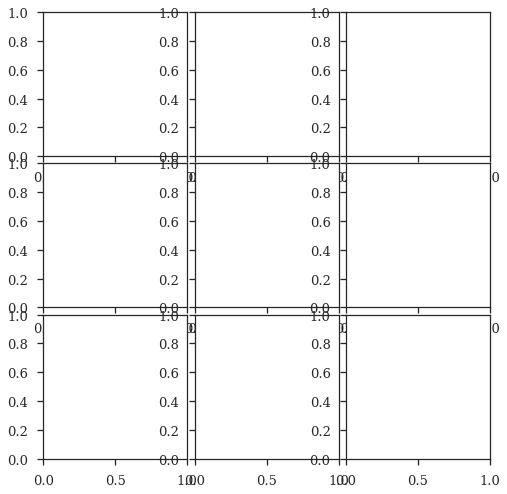

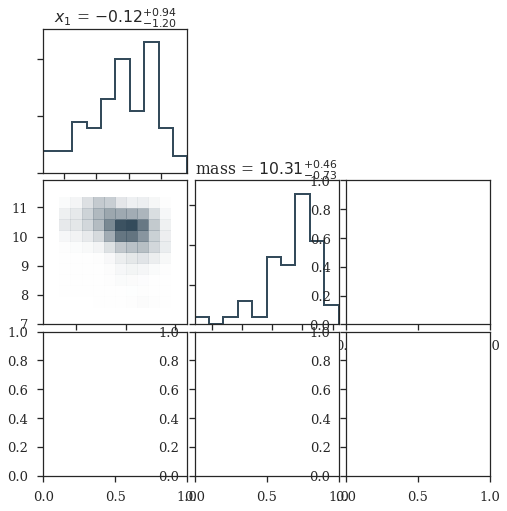

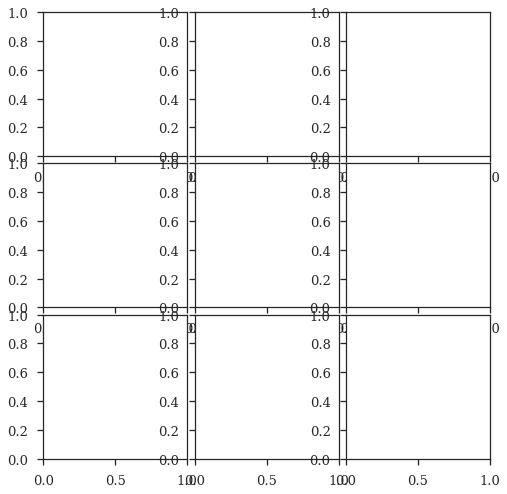

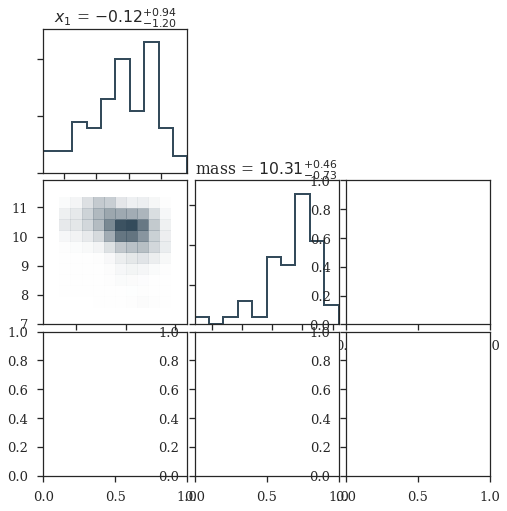

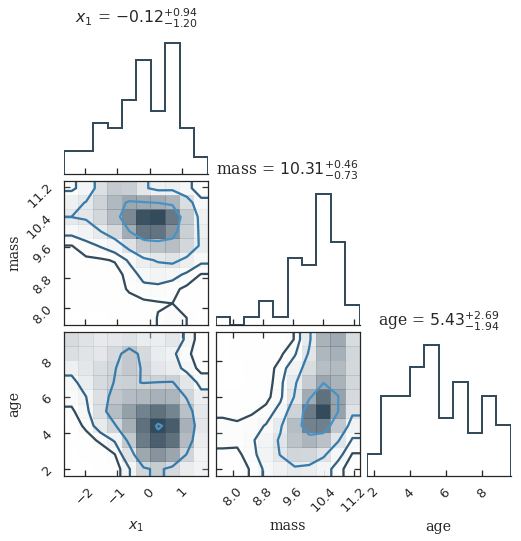

In [107]:
# features = ['x1', 'color', 'stellar mass', 'age']
features = ['x1', 'stellar mass', 'age']
data_compare = data.loc[:, features].values

plt.figure()

fig = corner.corner(data_compare, show_titles=True, use_math_text=True,
#                     quantiles=[0.16, .50, 0.84], 
                    smooth=1, bins=10,
                    plot_datapoints=False,
#                     labels=[r'$x_1$', r'log(M/M$_{\odot}$)', 'age [Gyr]']#, range=[0.99]*8
                    labels=[r'$x_1$', r'mass', 'age'],
                    hist_kwargs={'lw': '2'},
                    contour_kwargs={'levels': np.logspace(-0.5,1,6),
                                    'norm': matplotlib.colors.LogNorm(),  # Scale the colors to be on a log scale
                                    'colors': sns.color_palette("Blues_d")
#                                     'colors': sns.dark_palette("Blue")
                                   },
                    color=sns.color_palette("Blues_d")[0]  # Try to get this to pcolormesh, and one per dataset
                    )

#fix axes
ax_list = fig.axes
for i, ax in enumerate(ax_list):
    if i in [0, 4, 8]:
        # fix 1D-histogram plots
        ax.tick_params(axis='x', direction='in')  # set bottom ticks in
        ax.get_yaxis().set_ticks([])  # turn off top ticks
        sns.despine(left=True, ax=ax)  # despine
    else:
        # fix 2D-histogram plots (and blacks)
        ax.tick_params(axis='both', top='on', right='on', direction='in')

# plt.savefig('x1-mass-Lage-compare2.pdf')
plt.show()

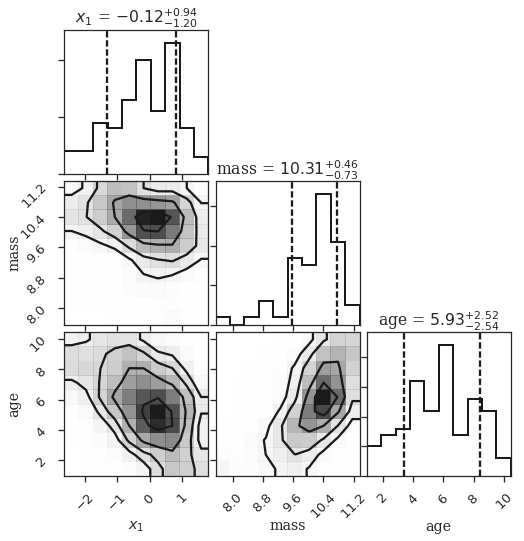

In [44]:
# Global

#features = ['x1', 'color', 'stellar mass', 'age']
features = ['x1', 'stellar mass', 'age']
data_compare = data_global.loc[:, features].values

plt.figure()
fig = corner.corner(data_compare, show_titles=True, use_math_text=True,
                    quantiles=[0.16, 0.84], smooth=1, bins=10,
                    plot_datapoints=False,
#                     labels=[r'$x_1$', r'log(M/M$_{\odot}$)', 'age [Gyr]']#, range=[0.99]*8
                    labels=[r'$x_1$', r'mass', 'age'],
                    hist_kwargs={'lw': '2'}
                    )

plt.savefig('x1-mass-Gage-compare.pdf')
plt.show()

## Other stuff

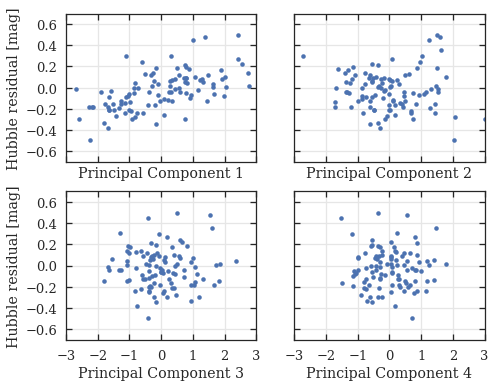

In [65]:
sns.set(context='talk', style='ticks', font='serif', color_codes=True)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(7.5, 6))

ax1.plot(principalComponents2[:,0], data['hr'], '.')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Hubble residual [mag]')

ax2.plot(principalComponents2[:,1], data['hr'], '.')
ax2.set_xlabel('Principal Component 2')
# ax2.set_ylabel('Hubble residual [mag]')

ax3.plot(principalComponents2[:,2], data['hr'], '.')
ax3.set_xlabel('Principal Component 3')
ax3.set_ylabel('Hubble residual [mag]')

ax4.plot(principalComponents2[:,3], data['hr'], '.')
ax4.set_xlabel('Principal Component 4')
# ax4.set_ylabel('Hubble residual [mag]')

#fix axes major spacing & size
ax1.get_yaxis().set_major_locator(MultipleLocator(0.2))
ax3.get_yaxis().set_major_locator(MultipleLocator(0.2))
ax1.set_ylim(-0.7, 0.7)
ax3.set_ylim(-0.7, 0.7)
ax1.get_xaxis().set_major_locator(MultipleLocator(1))
ax2.get_xaxis().set_major_locator(MultipleLocator(1))
ax1.set_xlim(-3, 3)
ax2.set_xlim(-3, 3)

#set axes ticks and gridlines
ax1.tick_params(axis='both', top='on', right='on', direction='in')
ax1.grid(which='major', axis='both', color='0.90', linestyle='-')
ax1.set_axisbelow(True)
ax2.tick_params(axis='both', top='on', right='on', direction='in')
ax2.grid(which='major', axis='both', color='0.90', linestyle='-')
ax2.set_axisbelow(True)
ax3.tick_params(axis='both', top='on', right='on', direction='in')
ax3.grid(which='major', axis='both', color='0.90', linestyle='-')
ax3.set_axisbelow(True)
ax4.tick_params(axis='both', top='on', right='on', direction='in')
ax4.grid(which='major', axis='both', color='0.90', linestyle='-')
ax4.set_axisbelow(True)

plt.show()

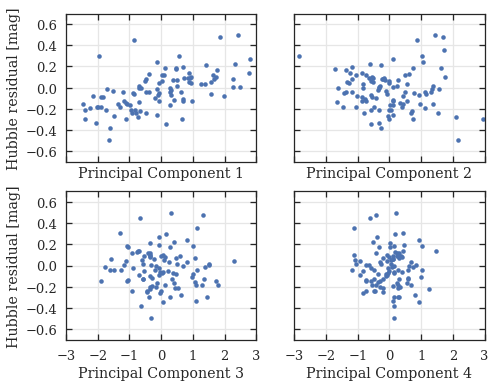

In [66]:
sns.set(context='talk', style='ticks', font='serif', color_codes=True)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(7.5, 6))

ax1.plot(principalComponents_global[:,0], data['hr'], '.')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Hubble residual [mag]')

ax2.plot(principalComponents_global[:,1], data['hr'], '.')
ax2.set_xlabel('Principal Component 2')
# ax2.set_ylabel('Hubble residual [mag]')

ax3.plot(principalComponents_global[:,2], data['hr'], '.')
ax3.set_xlabel('Principal Component 3')
ax3.set_ylabel('Hubble residual [mag]')

ax4.plot(principalComponents_global[:,3], data['hr'], '.')
ax4.set_xlabel('Principal Component 4')
# ax4.set_ylabel('Hubble residual [mag]')

#fix axes major spacing & size
ax1.get_yaxis().set_major_locator(MultipleLocator(0.2))
ax3.get_yaxis().set_major_locator(MultipleLocator(0.2))
ax1.set_ylim(-0.7, 0.7)
ax3.set_ylim(-0.7, 0.7)
ax1.get_xaxis().set_major_locator(MultipleLocator(1))
ax2.get_xaxis().set_major_locator(MultipleLocator(1))
ax1.set_xlim(-3, 3)
ax2.set_xlim(-3, 3)

#set axes ticks and gridlines
ax1.tick_params(axis='both', top='on', right='on', direction='in')
ax1.grid(which='major', axis='both', color='0.90', linestyle='-')
ax1.set_axisbelow(True)
ax2.tick_params(axis='both', top='on', right='on', direction='in')
ax2.grid(which='major', axis='both', color='0.90', linestyle='-')
ax2.set_axisbelow(True)
ax3.tick_params(axis='both', top='on', right='on', direction='in')
ax3.grid(which='major', axis='both', color='0.90', linestyle='-')
ax3.set_axisbelow(True)
ax4.tick_params(axis='both', top='on', right='on', direction='in')
ax4.grid(which='major', axis='both', color='0.90', linestyle='-')
ax4.set_axisbelow(True)

plt.show()

Other stuff

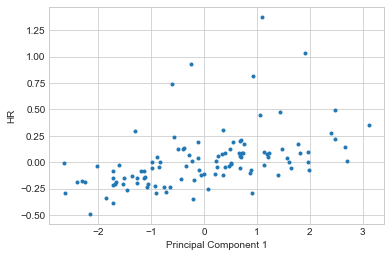

In [64]:
plt.plot(principalComponents2[:,0], data['hr'], '.')
plt.xlabel('Principal Component 1')
plt.ylabel('HR')
# plt.savefig('HRvPCA1.pdf')
plt.show()

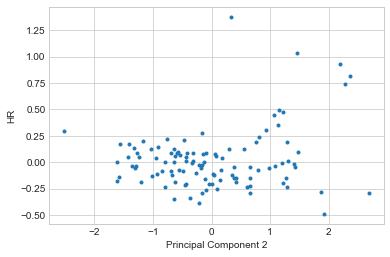

In [65]:
plt.plot(principalComponents2[:,1], data['hr'], '.')
plt.xlabel('Principal Component 2')
plt.ylabel('HR')
# plt.savefig('HRvPCA2.pdf')
plt.show()

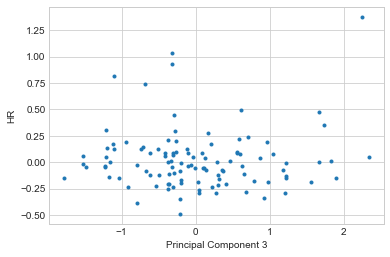

In [66]:
plt.plot(principalComponents2[:,2], data['hr'], '.')
plt.xlabel('Principal Component 3')
plt.ylabel('HR')
# plt.savefig('HRvPCA3.pdf')
plt.show()

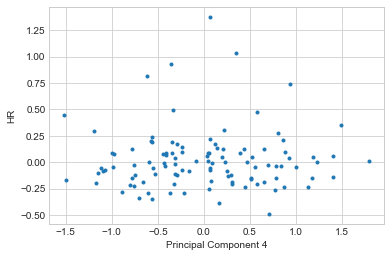

In [67]:
plt.plot(principalComponents2[:,3], data['hr'], '.')
plt.xlabel('Principal Component 4')
plt.ylabel('HR')
# plt.savefig('HRvPCA4.pdf')
plt.show()

[ 0.53352587, -0.04696966, -0.56537291, -0.62729377] of x1, color, stellar mass, and age.

* color has no effect.
* x1 shows that it is different SNIa, of our standard definitions.
* stellar mass and age have a negative correlation of almost equal weight, but age is slightly stronger.


### PCA without HR and without objects with HR < 0.5

Removes 5 objects

In [ ]:
data[data['hr']>=0.5]['hr']

In [57]:
features = ['x1', 'color', 'stellar mass', 'age']
z = data[data['hr']<0.5].loc[:, features].values
z = StandardScaler().fit_transform(z)
z.shape

(103, 4)

In [58]:
pca3 = PCA(n_components=4)
principalComponents3 = pca3.fit_transform(z)

In [60]:
pca3.components_

array([[ 0.54259113, -0.10542863, -0.56066036, -0.61655465],
       [-0.16048507,  0.95949048, -0.1897051 , -0.13279506],
       [-0.73930618, -0.25248866, -0.622891  , -0.04102012],
       [ 0.36505586,  0.06717357, -0.51154544,  0.77494722]])

In [61]:
pca3.singular_values_

array([ 13.5253809 ,  10.21837964,   8.49723135,   7.2419506 ])

In [72]:
pca3.explained_variance_ratio_

array([ 0.44401924,  0.25343515,  0.17524986,  0.12729575])

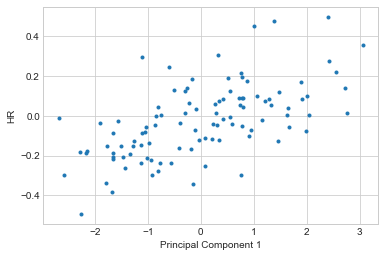

In [73]:
plt.plot(principalComponents3[:,0], data[data['hr']<0.5]['hr'], '.')
plt.xlabel('Principal Component 1')
plt.ylabel('HR')
plt.savefig('HRvPCA1.pdf')
plt.show()

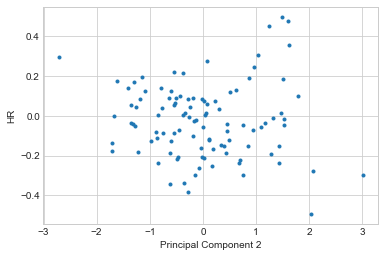

In [74]:
plt.plot(principalComponents3[:,1], data[data['hr']<0.5]['hr'], '.')
plt.xlabel('Principal Component 2')
plt.ylabel('HR')
plt.savefig('HRvPCA2.pdf')
plt.show()

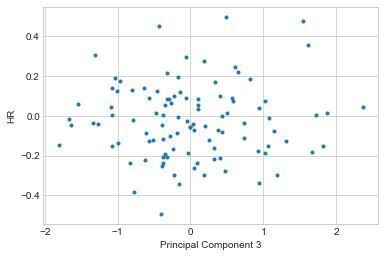

In [75]:
plt.plot(principalComponents3[:,2], data[data['hr']<0.5]['hr'], '.')
plt.xlabel('Principal Component 3')
plt.ylabel('HR')
plt.savefig('HRvPCA3.pdf')
plt.show()

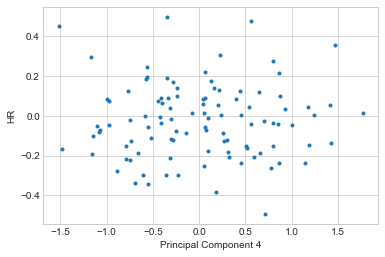

In [76]:
plt.plot(principalComponents3[:,3], data[data['hr']<0.5]['hr'], '.')
plt.xlabel('Principal Component 4')
plt.ylabel('HR')
plt.savefig('HRvPCA4.pdf')
plt.show()

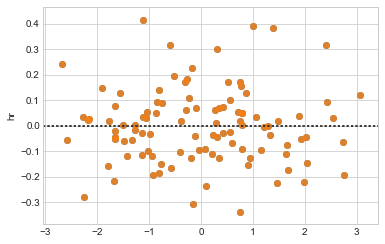

In [81]:
sns.residplot(principalComponents3[:,0], data[data['hr']<0.5]['hr'])
plt.show()